In [27]:
import numpy as np
import pandas as pd

# from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

In [28]:
train = pd.read_csv('contest_train.csv')
test = pd.read_csv('contest_test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [29]:
train.shape, test.shape

((210000, 32), (90000, 31))

In [30]:
X = train.drop(columns=['id', 'target'])
y = train['target']

# X_test = test.drop(columns=['id'])

In [31]:
cat_features = X.select_dtypes(include='object').columns.tolist()
num_features = X.select_dtypes(exclude='object').columns.tolist()

In [32]:
len(cat_features), len(num_features)

(19, 11)

In [33]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features),
        ('num', StandardScaler(), num_features)
    ]
)

In [34]:
model_logreg = LogisticRegression(
    max_iter=1000,
    n_jobs=-1
)

In [35]:
# model_cat = CatBoostClassifier(
#     iterations=800,
#     depth=8,
#     learning_rate=0.05,
#     loss_function='Logloss',
#     eval_metric='AUC',
#     random_seed=42,
#     early_stopping_rounds=50,
#     verbose=100
# )

In [36]:
pipeline = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('model', model_cat)
    ]
)

In [37]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [38]:
X_train.shape, X_val.shape

((168000, 30), (42000, 30))

In [39]:
pipeline.fit(X_train, y_train)

/Users/user/.pyenv/versions/3.14.0/lib/python3.14/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [40]:
val_proba = pipeline.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, val_proba)
print("ROC-AUC:", roc_auc)

ROC-AUC: 0.8815590869308101


In [41]:
y_pred = (val_proba >= 0.5).astype(int)

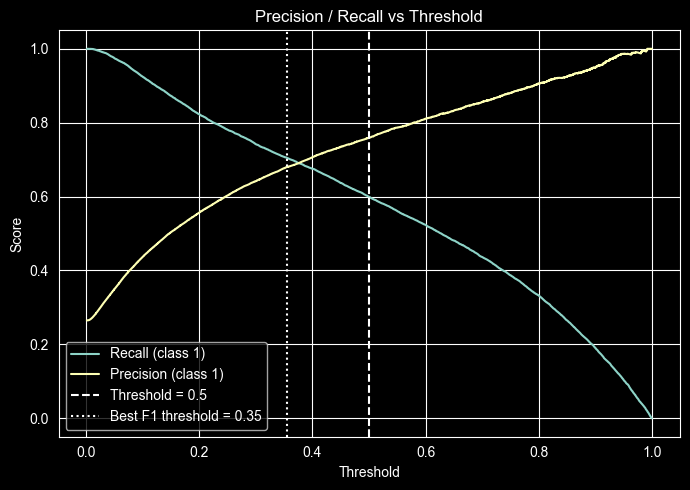

Best threshold (by F1): 0.355
Best F1-score: 0.692


In [42]:
# Precision–Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_val, val_proba)

# Подбор порога по F1
thresholds = np.linspace(0.0, 1.0, 201)

best_threshold = 0.0
best_f1 = 0.0

for t in thresholds:
    y_pred_t = (val_proba >= t).astype(int)
    f1 = f1_score(y_val, y_pred_t)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

# ===== Plot =====
plt.figure(figsize=(7, 5))

plt.plot(pr_thresholds, recall[:-1], label='Recall (class 1)')
plt.plot(pr_thresholds, precision[:-1], label='Precision (class 1)')

plt.axvline(0.5, linestyle='--', label='Threshold = 0.5')
plt.axvline(best_threshold, linestyle=':', label=f'Best F1 threshold = {best_threshold:.2f}')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision / Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ===== Result =====
print(f"Best threshold (by F1): {best_threshold:.3f}")
print(f"Best F1-score: {best_f1:.3f}")

In [43]:
threshold = best_threshold
y_pred = (val_proba >= threshold).astype(int)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_val, y_pred))
print("\nClassification report:\n", classification_report(y_val, y_pred))

Accuracy: 0.8340238095238095
Confusion matrix:
 [[27188  3687]
 [ 3284  7841]]

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.89     30875
           1       0.68      0.70      0.69     11125

    accuracy                           0.83     42000
   macro avg       0.79      0.79      0.79     42000
weighted avg       0.84      0.83      0.83     42000



hyper param tunic
cross validaion